## Outlier Detection using Statistical Methods


* point outliers - a data point that deviates from the rest of the population
* collective outliers - groups of observations, differ from the population and don't follow the expected pattern
* contextual outliers - when an observation is considered an outlier based on a particular condition or context, such as deviation from neighboring data points

_Change Point Detection (CPD)_:
 - relates to outlier detection
 - the goal is to anticipate abrupt and impactful fluctuations in the time series data 
 
 CPD covers specific techniques, for example:
  * cumulative sum (CUSUM)
  * Bayesian online change point detection (BOCPD)

This chapter will walk through:
* Resampling time series data 
* Detecting outliers using visualizations 
* Detecting outliers using the Tukey method 
* Detecting outliers using a z-score 
* Detecting outliers using a modified z-score

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [4]:
file = Path("../TimeSeriesAnalysisWithPythonCookbook/Data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, index_col='timestamp', parse_dates=True)
nyc_taxi.index.freq = '30T'

In [6]:
# Store the known dates containing outliers, also known as ground truth labels 
nyc_dates = [
    '2014-11-01', 
    '2014-11-27',
    '2014-12-25',
    '2014-01-01',
    '2014-01-27',
]


<AxesSubplot:title={'center':'NYC Taxi'}, xlabel='timestamp'>

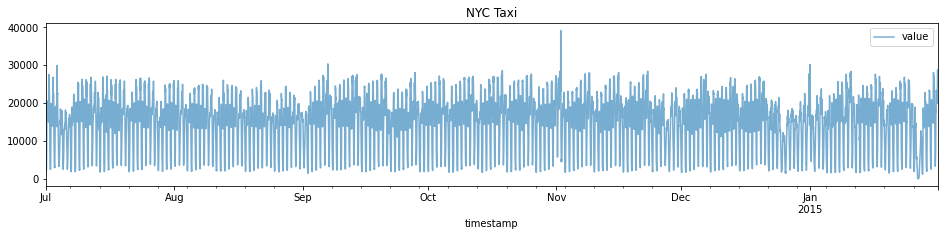

In [7]:
# We can plot the time series data to gain an intuition on the data we will be working with for our outlier detection
nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

In [8]:
# Create a plot_outliers function that we will use repeatedly

def plot_outliers(outliers, data, method='KNN', 
                  halignment = 'right', 
                  valignment = 'bottom', 
                  labels = False):
    ax = data.plot(alpha=0.6)

    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                     horizontalalignment=halignment, 
                     verticalalignment=valignment)
    else: 
        data.loc[outliers.index].plot(ax=ax, style='rx')

    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi', 'outliers'])
    plt.show()

## Understanding Outliers 

#### Resampling time series data 

 - a typical transformation that is done on time series data is resampling
 - the process implies changing the frequency or level of granularity of the data
 
 Downsampling
 - for instance going from daily data to weekly data
 - when downsampling we will need to do some level of aggregation, such as mean, sum, min or max

 Upsampling:
 - for instance going from daily to hourly
 - when upsampling we will end up with null rows, which we must fill either using imputation or interpolation techniques
 

In [10]:
# Downsample the data to a daily frequency
# resampling is done using the DataFrame.resample() function
# For daily, we will use 'D' as the date offset rule, followed by .mean()

df_downsampled = nyc_taxi.resample('D').mean()
df_downsampled

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


In [11]:
# inspect the first DatetimeIndex to check its frequency
df_downsampled.index[0]


Timestamp('2014-07-01 00:00:00', freq='D')

In [12]:
# We can also check frequency directly using the .freq property
df_downsampled.index.freq

<Day>

In [13]:
# Check the number of records now after downsampling 
df_downsampled.shape 

(215, 1)

In [15]:
# Resample the data again, but this time as a 3-day frequency
# We can do this by using '3D'
# This time use the .sum() method instead 
df_downsampled = nyc_taxi.resample('3D').sum()
df_downsampled.head()

,value
timestamp,
2014-07-01,2189749
2014-07-04,1658320
2014-07-07,2111672
2014-07-10,2335629
2014-07-13,2139711


In [16]:
# Check the frequency of DatetimeIndex 
df_downsampled.index.freq

<3 * Days>

In [18]:
# Now change the frequency to 3 business days instead
df_downsampled = nyc_taxi.resample('3B').sum()
df_downsampled.head()

,value
timestamp,
2014-07-01,2189749
2014-07-04,3021425
2014-07-09,3799847
2014-07-14,2174540
2014-07-17,3711232


In [19]:
# Upsample the data from a 30-minute interval to a 15-minutes frequency
# This will create an empty entry (NaN) between every other entry
# We will use 'T' for minutes, since 'M' is used for monthly aggregation

nyc_taxi.resample('15T').mean().head()

#Notice that upsampling creates NaN rows. Unlike downsampling, when upsampling we need to give instructions 
# on how to fill the NaN rows



,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [20]:
# We can supply more than one aggregation at once when downsampling using the .agg() function
# For example using 'M' for monthly, we can supply the .agg() function with a list of aggregations we want to perform
nyc_taxi.resample('M').agg(['mean', 'min', 'max', 'median', 'sum'])


value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889

## Detecting outliers using visualizations 